Will investigate the following 2 reviewer comments here:
(1) Is it possible to optimize the geometry? Or transition states and reaction paths? Perhaps this is the next step, but it would be essential to map out how strong coupling affects chemistry. For the Mg-Br system, is there an effect of the strong coupling on the ground state equilibrium?

(2) Somewhat related to my previous comments on the field strength: The diffference between the simple Jaynes-Cummings-like model (eq. 22) and the CQED-CIS method is very interesting to see, but how strong does the field need to be in order to see these differences. Might it be that for moderate fields, which may be more in line with experiment, in particular for optical cavities, the differences would dissappear?
Still needs to be addressed.



In [37]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


Methods to fit Pauli-Fierz and Jaynes-Cummings models to CIS data for the ground- and excited-state
of a quantum system (including transition dipole moments in both cases, and the total dipole
moments in the Pauli-Fierz case) given a photon frequency and coupling strength.

In [22]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    vecs = vecs[:,idx]
    return vals[0], vals[1], vals[2], vecs

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


Virtual photons in the resonant Lorentz model. a Number of photons in the resonant mode ck = ω 0 as a function of the coupling for γ L = 0 (thin blue line), 0.5ω 0 (solid cyan line), ω 0 (dash-dotted green line), 1.5ω 0 (dashed magenta line) and 2ω 0 (dotted red line),

In [34]:
# template for z-matrix
molstr = """
Mg
H 1 2.2
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options
psi4.set_options(options_dict)

# array to hold the cs-cqed-cis energies
cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array to hold the photon occupations of the ground state
po = np.zeros((2,n_lam))

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

# photon energy
om_r = 4.75 / 27.211
gam = 0.5 / 27.211

molstr = mol_tmpl
n_lam = 20
# electric field strength 
lam_z = np.linspace(0, 0.025, n_lam) 


#print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - gam * 1j

# lambda vector
#lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
ctr = 0
for l in lam_z:
    lam = np.array([0, 0, l])
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    #cis_e, cis_c, cis_mu, tdm = cis(molstr, options_dict)
    
    #cis_energy_array[0,ctr] = e
    #cis_energy_array[0,ctr] = e+psi4_excitation_e[0]
    
    #pf[0,ctr], pf[1,ctr], pf[2,ctr], vecs = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    #jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    #pf_c_g0 = vecs[:,n_state]
    #print(pf_c_g0)
    
    assert np.isclose(cis_e[0], psi4_excitation_e[0])
    assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict_r = cs_cqed_cis(lam, om_r, molstr, options_dict)
    cqed_dict_c = cs_cqed_cis(lam, om, molstr, options_dict)
    Cr_L = cqed_dict_r['CQED-CIS L VECTORS']
    Cc_L = cqed_dict_c['CQED-CIS L VECTORS']
    Cc_R = cqed_dict_c['CQED-CIS R VECTORS']
    real_phot_occ = 0.0 
    complex_phot_occ = 0.0
    for i in range(0, len(C_L[:,0])):
        if i%2==1:
            real_phot_occ += np.real(np.conj(Cr_L[i,n_state]) * Cr_L[i,n_state])
            complex_phot_occ += np.real(np.conj(Cc_L[i,n_state]) * Cc_R[i,n_state])
    
    # no loss
    po[0,ctr] = real_phot_occ
    # loss
    po[1,ctr] = complex_phot_occ
    #po_pf[ctr] = np.real(pf_c_g0[1]*np.conj(pf_c_g0[1]))
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total time for SCF iterations: 0.005 seconds 

QED-RHF   energy: -199.86395910 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total tim


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6659585851016914
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0005139203077781
SCF Iteration   1: Energy = -199.8636177469930146   dE = -1.99864E+02   dRMS = 1.37409E-05
SCF Iteration   2: Energy = -199.8636180927399266   dE = -3.45747E-07   dRMS = 5.20283E-06
SCF Iteration   3: Energy = -199.8636181341299221   dE = -4.13900E-08   dRMS = 1.97152E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.86361813 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6659833857856370
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0006712428509754
SCF Iteration   1: Energy = -199.8635132498923497   dE = -1.99864E+02   dRMS = 1.79433E-05
SCF Itera


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6661569905734837
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0017725006533570
SCF Iteration   1: Energy = -199.8627817701870413   dE = -1.99863E+02   dRMS = 4.73608E-05
SCF Iteration   2: Energy = -199.8627858602161780   dE = -4.09003E-06   dRMS = 1.78169E-05
SCF Iteration   3: Energy = -199.8627863443771844   dE = -4.84161E-07   dRMS = 6.73197E-06
SCF Iteration   4: Energy = -199.8627864132922696   dE = -6.89151E-08   dRMS = 2.56319E-06
Total time for SCF iterations: 0.009 seconds 

QED-RHF   energy: -199.86278641 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6662016318043129
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0020556812311123
SCF Itera


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0037862292062834
SCF Iteration   1: Energy = -199.8614442072973247   dE = -1.99861E+02   dRMS = 1.01153E-04
SCF Iteration   2: Energy = -199.8614627491085685   dE = -1.85418E-05   dRMS = 3.76713E-05
SCF Iteration   3: Energy = -199.8614649046415366   dE = -2.15553E-06   dRMS = 1.41700E-05
SCF Iteration   4: Energy = -199.8614652077042706   dE = -3.03063E-07   dRMS = 5.36938E-06
SCF Iteration   5: Energy = -199.8614652513527119   dE = -4.36484E-08   dRMS = 2.04455E-06
Total time for SCF iterations: 0.013 seconds 

QED-RHF   energy: -199.86146525 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy    

In [36]:
lam = np.array([0, 0, l])
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# confirm our cis agrees with psi4
res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
assert np.isclose(cis_e[0], psi4_excitation_e[0])
assert np.isclose(cis_e[1], psi4_excitation_e[1])
cqed_dict_r = cs_cqed_cis(lam, om_r, molstr, options_dict)
cqed_dict_c = cs_cqed_cis(lam, om, molstr, options_dict)


cqed_cis_e_r = cqed_dict_r['CQED-CIS ENERGY']
cqed_cis_e_c = cqed_dict_c['CQED-CIS ENERGY']

print(cqed_cis_e_r[0:5])
print(cqed_cis_e_c[0:5])



Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0037862292062834
SCF Iteration   1: Energy = -199.8614442072973247   dE = -1.99861E+02   dRMS = 1.01153E-04
SCF Iteration   2: Energy = -199.8614627491085685   dE = -1.85418E-05   dRMS = 3.76713E-05
SCF Iteration   3: Energy = -199.8614649046415366   dE = -2.15553E-06   dRMS = 1.41700E-05
SCF Iteration   4: Energy = -199.8614652077042706   dE = -3.03063E-07   dRMS = 5.36938E-06
SCF Iteration   5: Energy = -199.8614652513527119   dE = -4.36484E-08   dRMS = 2.04455E-06
Total time for SCF iterations: 0.013 seconds 

QED-RHF   energy: -199.86146525 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6664744393278852
Nuclear repulsion energy    

No handles with labels found to put in legend.


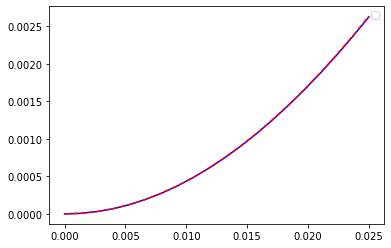

In [35]:


#plt.plot(lam_z, cis_energy_array[0,:]+om, 'red', label='X,1')
#plt.plot(lam_z, cis_energy_array[1,:], 'blue', label='A,0')
####plt.plot(lam_z, np.real(jc[0,:]), 'b--', label="JC LP")
####plt.plot(lam_z, np.real(jc[1,:]), 'g--', label="JC UP")
#plt.plot(lam_z, np.real(pf[1,:]), 'b-*', label="PF LP")
#plt.plot(lam_z, np.real(pf[2,:]), 'g-*', label="PF UP")
####plt.plot(lam_z, np.real(cqed_cis_energy_array[1,:]), 'bo', label="CQED-CIS LP")
####plt.plot(lam_z, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")
plt.plot(lam_z, po[0,:], 'blue')
plt.plot(lam_z, po[1,:], 'r--')
plt.legend()
plt.show()

In [ ]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

Run the cell below to compute the data for Figure 2: scan of ground-state energy
of MgH+ coupled to a photon with energy 4.75 eV and lambda = 0.075 atomic units polarized along z
at the RHF/cc-pVDZ, CQED-RHF/cc-pVDZ, and CQED-CIS/cc-pVDZ levels.

Write the data to a file!

In [ ]:
# plot the ground-state potential energy surfaces
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.legend()
plt.show()


In [ ]:
# write the data to file!
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()